# Data Science Project: Planning Stage (Individual)

In [58]:
library(tidyverse)
library(tidymodels)
library(lubridate)
options(repr.matrix.max.rows = 6)

## (1) Data Description

In [59]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [60]:
glimpse(players)

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


## Players

| Attribute             | Detail                    |
| :-------------------- | :------------------------ |
| **Number of rows**    | 196 observations          |
| **Number of columns** | 7                         |
| **Data Collection**   | from the Minecraft server |

---

### Variables

| Variable Name  | Type      | Meaning                                                            |
| :------------- | :-------- | :----------------------------------------------------------------- |
| `experience`   | character | Player’s self-reported experience (Pro, Veteran, Amateur, Regular) |
| `subscribe`    | logical   | Whether the player is subscribed to the newsletter                 |
| `hashedEmail`  | chr       | Hashed email to link players to sessions                           |
| `played_hours` | double    | Hours played on the server                                         |
| `name`         | chr       | Player’s preferred name                                            |
| `gender`       | chr       | Player’s preferred gender                                          |
| `age`          | dbl       | Player’s age                                                       |

---

### Missing Values or Inconsistencies

* Ahmed has gender as Other and no age—this observation could be removed.
* Devin did not report age but has gender—can be used for gender analysis but not age.
* Rare gender categories (e.g., Non-Binary, Two-Spirited) may cause uneven distributions for comparisons.

---

### Potential Issues Not Visible

* Self-reported data may introduce bias in age, experience, or play habits.
* Certain player types (e.g., new or inactive) may be underrepresented, biasing results toward active users.
* Hashed emails could contain errors or corruption, which is important as they link players to sessions.

In [61]:
glimpse(sessions)

Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…


## Sessions

| Attribute             | Detail                    |
| :-------------------- | :------------------------ |
| **Number of rows**    | 1535 observations         |
| **Number of columns** | 5                         |
| **Data Collection**   | from the Minecraft server |

---

### Variables

| Variable Name         | Type | Meaning                                      |
| :-------------------- | :--- | :------------------------------------------- |
| `hashedEmail`         | chr  | Hashed email linking the session to a player |
| `start_time`          | chr  | Session start datetime                       |
| `end_time`            | chr  | Session end datetime                         |
| `original_start_time` | dbl  | Numeric representation of session start      |
| `original_end_time`   | dbl  | Numeric representation of session end        |

---

### Missing Values or Inconsistencies

* No obvious issues; sessions are recorded at various times throughout the day.

---

### Potential Issues Not Visible

* Converting `start_time` and `end_time` to proper datetime format would improve accuracy and usability.
* Hashed emails could contain errors or corruption, which is important as they link players to sessions.

## (2) Questions

## Demand Forecasting: Predicting Active Players

### Broad Goal

"We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. "

---

### Specific Question

**Can day of week and time of day predict the number of active players?**

| Component           | Variable                 | Details                             |
| :------------------ | :----------------------- | :---------------------------------- |
| **Response (Y)**    | Number of active players | Current server load                 |
| **Explanatory (X)** | Day of week, Time of day | Factors influencing player activity |

---

### Importance

* Identify peak periods to prepare server capacity and licenses.
* Adjust resources dynamically to save costs.
* Determine maximum and minimum licenses needed for budgeting and expansion.

---

### Method

* Add `day_of_week` and `hour_of_day` to session data (`wday()`, `hour()`), converting day to a factor and hour to numeric or categories.
* Group by these variables and calculate average active players.
* Visualizations: average players by day (`geom_col()`) and by hour (`geom_line()` + `geom_point()`).

## (3) Exploratory Data Analysis and Visualization

In [69]:
sessions_clean <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),
    end_time = dmy_hm(end_time)
  )

sessions_clean

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12


In [70]:
players |>
  summarize(
    mean_age = mean(Age, na.rm = TRUE),
    mean_played_hours = mean(played_hours, na.rm = TRUE)
  )


mean_age,mean_played_hours
<dbl>,<dbl>
21.13918,5.845918


The average player is 21 years old and has played 5–6 hours, outlining the typical player profile.


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


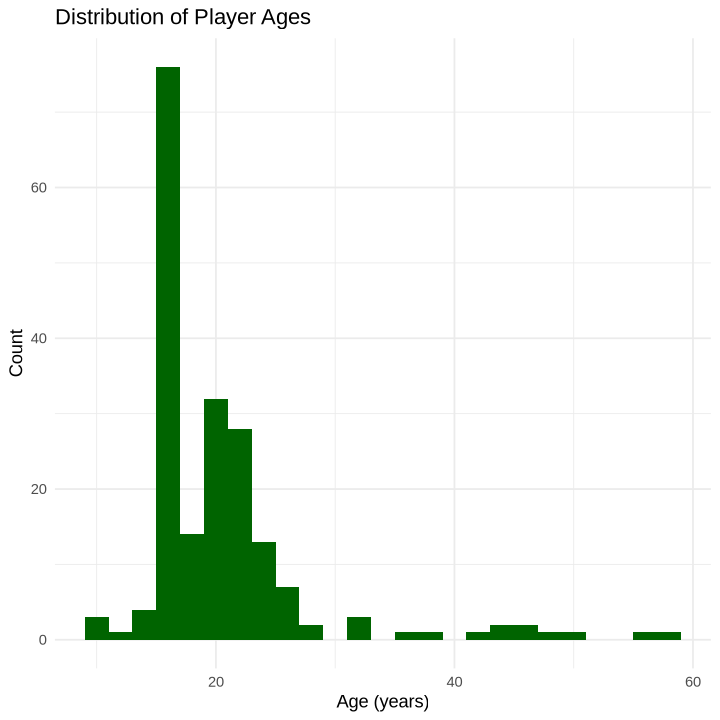

In [71]:
options(repr.plot.width = 6, repr.plot.height = 6)

players |>
  ggplot(aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "darkgreen") +
  labs(
    title = "Distribution of Player Ages",
    x = "Age (years)",
    y = "Count"
  ) +
  theme_minimal()

Most players are 15–25, with 17 most common, indicating students and helping predict peak activity times.

In [72]:
sessions_time <- sessions_clean |>
  mutate(
    day_of_week = wday(start_time, label = TRUE),
    hour_of_day = hour(start_time)
  )
sessions_time

hashedEmail,start_time,end_time,original_start_time,original_end_time,day_of_week,hour_of_day
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<ord>,<int>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12,Sun,18
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12,Mon,23
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12,Thu,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12,Sun,15
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12,Thu,6
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12,Mon,2


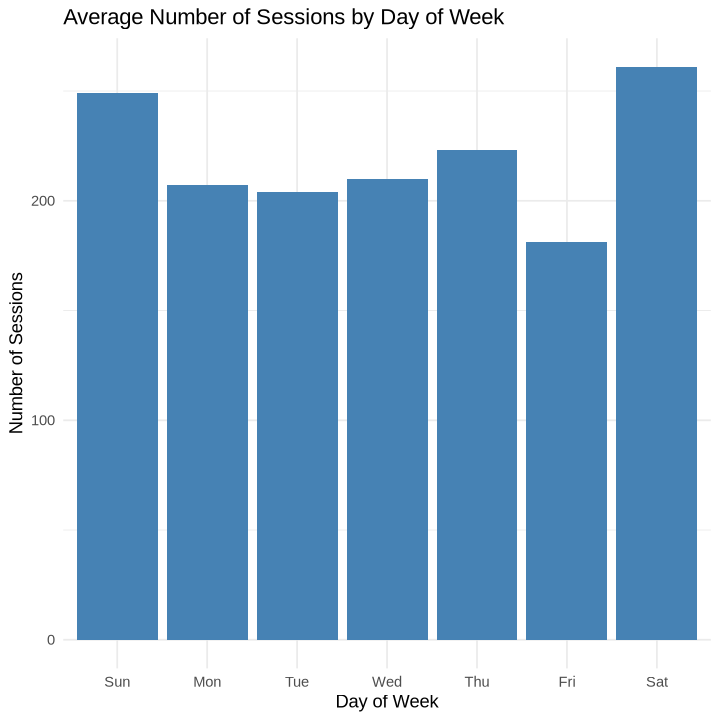

In [73]:
sessions_time |>
  group_by(day_of_week) |>
  summarize(avg_sessions = n()) |>
  ggplot(aes(x = day_of_week, y = avg_sessions)) +
  geom_col(fill = "steelblue") +
  labs(
    title = "Average Number of Sessions by Day of Week",
    x = "Day of Week",
    y = "Number of Sessions"
  ) +
  theme_minimal()


There are many daily sessions, with noticeable differences on Saturday and Sunday.

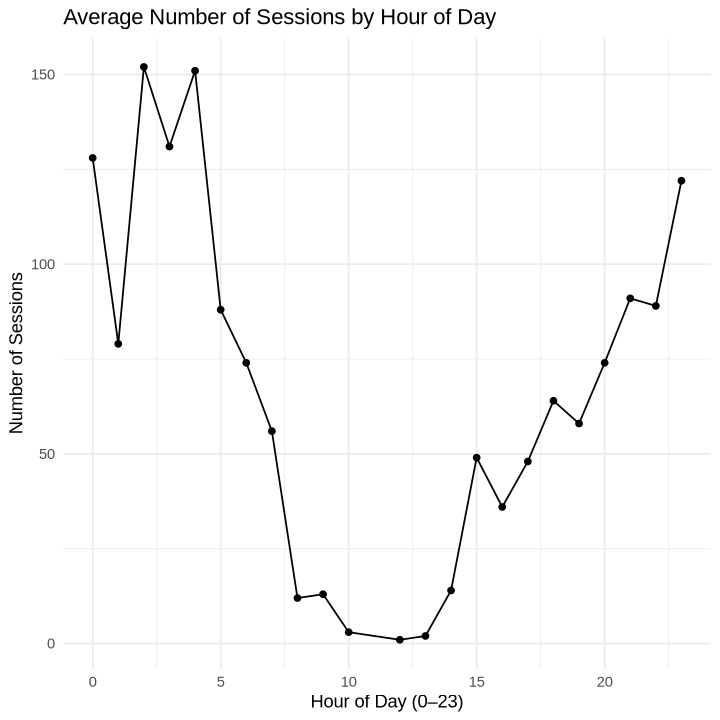

In [74]:
sessions_time |>
  group_by(hour_of_day) |>
  summarize(avg_sessions = n()) |>
  ggplot(aes(x = hour_of_day, y = avg_sessions)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Average Number of Sessions by Hour of Day",
    x = "Hour of Day (0–23)",
    y = "Number of Sessions"
  ) +
  theme_minimal()


Sessions are high between 12–4 a.m., drop during work hours (7 a.m.–1 p.m.), and rise sharply after 3 p.m. as players return home.

# (4) Methods and Plan


### Method Chosen: K-Nearest Neighbours (KNN) Regression

**Why KNN:**

* Predicts numerical values (active player count) and handles non-linear relationships, fitting spikes in evening or weekend activity.

**Assumptions:**

* Players active at similar times show similar activity.
* Distances matter equally; data must be normalized.

**Limitations:**

* Can be slow with large datasets (approx. 1500 sessions is okay).
* Sensitive to noise/irrelevant variables.

**Model Selection:**

* Use 5-fold cross-validation to test K values (e.g., 1, 5, 20) and pick the lowest RMSE to avoid overfitting.

**Data Processing:**

* Convert `hour_of_day` and `day_of_week` to numeric/categorical and calculate active players per window.
* Normalize data, split 70/30 for training/testing, fit model with best K, and evaluate performance on test data.